In [73]:
import librosa  # for audio processing
import librosa.display
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile  # for audio processing
from numpy.lib.stride_tricks import as_strided
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import wavfile as wav
import sklearn
import pandas as pd
from os.path import exists
import sys
import os

import warnings
warnings.filterwarnings("ignore")

In [56]:
# importing local script
sys.path.append(os.path.abspath(os.path.join('../scripts/')))
#from audio_loder1 import *
#from data_exploration import *

In [57]:
fullpath  =('../data/train/wav/tr_10005_tr097087.wav')
librosa_load, librosa_sampling_rate = librosa.load(fullpath)
#scipy_sampling_rate, scipy_load = wav.read(fullpath)
print(librosa_load)
print(librosa_sampling_rate)




[-0.12053408 -0.13506676 -0.11417543 ... -0.12417331 -0.13603619
  0.        ]
22050


In [58]:
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs


In [59]:
spe_samples, frequency = spectrogram(librosa_load)
print(frequency)
print(spe_samples)

[0.        0.0078125 0.015625  0.0234375 0.03125   0.0390625 0.046875
 0.0546875 0.0625    0.0703125 0.078125  0.0859375 0.09375   0.1015625
 0.109375  0.1171875 0.125     0.1328125 0.140625  0.1484375 0.15625
 0.1640625 0.171875  0.1796875 0.1875    0.1953125 0.203125  0.2109375
 0.21875   0.2265625 0.234375  0.2421875 0.25      0.2578125 0.265625
 0.2734375 0.28125   0.2890625 0.296875  0.3046875 0.3125    0.3203125
 0.328125  0.3359375 0.34375   0.3515625 0.359375  0.3671875 0.375
 0.3828125 0.390625  0.3984375 0.40625   0.4140625 0.421875  0.4296875
 0.4375    0.4453125 0.453125  0.4609375 0.46875   0.4765625 0.484375
 0.4921875 0.5       0.5078125 0.515625  0.5234375 0.53125   0.5390625
 0.546875  0.5546875 0.5625    0.5703125 0.578125  0.5859375 0.59375
 0.6015625 0.609375  0.6171875 0.625     0.6328125 0.640625  0.6484375
 0.65625   0.6640625 0.671875  0.6796875 0.6875    0.6953125 0.703125
 0.7109375 0.71875   0.7265625 0.734375  0.7421875 0.75      0.7578125
 0.765625  0.77343

In [60]:
def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    # plt.savefig('spectogramfeature.png')

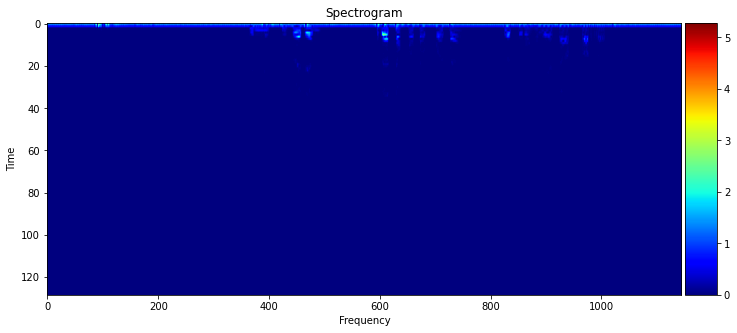

In [61]:
plot_spectrogram_feature(spe_samples)

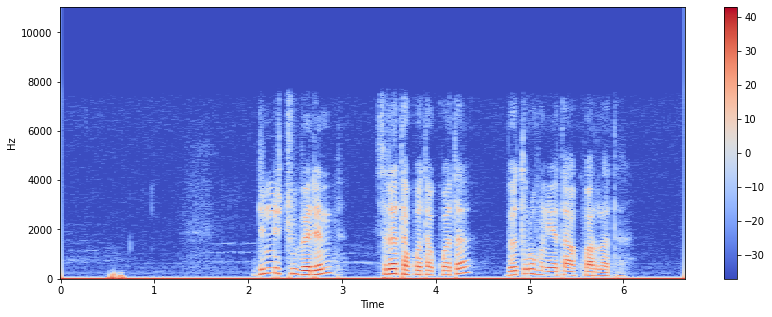

In [62]:
X = librosa.stft(librosa_load)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=librosa_sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()
# plt.savefig('specshow.png')

In [63]:
def plot_spec(data: np.array, sr: int) -> None:
    '''
    Function for plotting spectrogram along with amplitude wave graph
    '''

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].title.set_text(f'Shfiting the wave by Times {sr/10}')
    ax[0].specgram(data, Fs=2)
    ax[1].set_ylabel('Amplitude')
    ax[1].plot(np.linspace(0, 1, len(data)), data)
    # fig.savefig('spectogramamplitude.png')

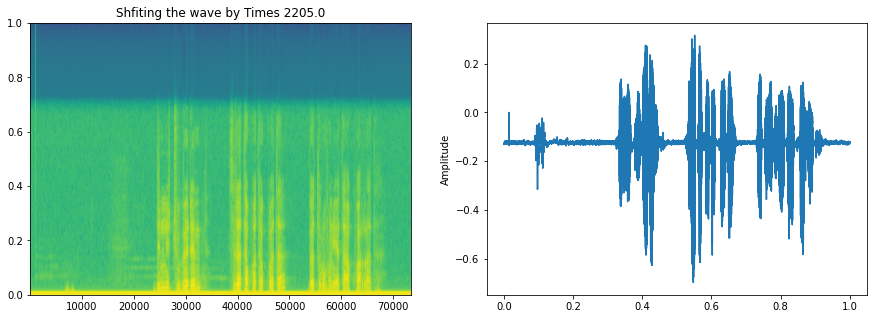

In [64]:
wav_roll = np.roll(librosa_load, int(librosa_sampling_rate/10))
plot_spec(data=wav_roll, sr=librosa_sampling_rate)

(20, 287)


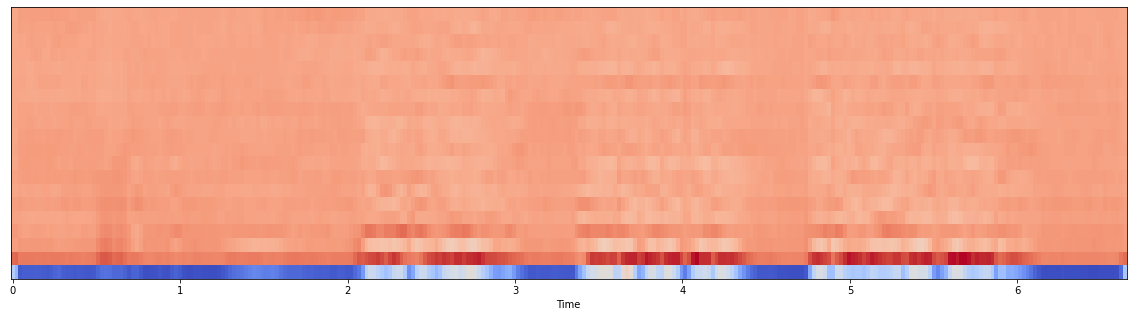

In [65]:
plt.figure(figsize=(20, 5))
mfccs = librosa.feature.mfcc(librosa_load, sr=librosa_sampling_rate)
librosa.display.specshow(mfccs, sr=librosa_sampling_rate, x_axis='time')
print(mfccs.shape)

In [66]:
##Function to create the metadata

def tran_loader(filename):
  name_to_text = {}
  with open (filename, encoding="utf-8")as f:
    f.readline()
    for line in f:
      name=line.split("</s>")[1]
      name=name.replace('(', '')
      name=name.replace(')', '')
      name=name.replace('\n','')
      name=name.replace(' ','')
      text=line.split("</s>")[0]
      text=text.replace("<s>","")
      name_to_text[name]=text
    return name_to_text

In [81]:
transcription=tran_loader("../data/train/trsTrain.txt")
transcription

{'tr_2_tr01002': ' የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስፖርት ና መጓጓዣ ገንዘብ ተሰጥቷ ቸው መሸኘታቸው ን አመልክቶ በ የ ዞ ናቸው እንደ ደረሱ መቃቋሚያ እንደሚ ሰጣቸው ም አስ ታውቋል ',
 'tr_3_tr01003': ' በ አዲስ አበባው ስታዲየም በ ተካሄዱ ት ሁለት ግጥሚያ ዎች በ መጀመሪያ የ ተገናኙ ት መድን ና ሙገር ሲሚንቶ ሲ ሆኑ በ ውጤቱ ም ሶስት ለ ሶስት ተለያይ ተዋል ',
 'tr_4_tr01004': ' ወሬው ን ወሬ ያደረጉ ምስጢረ ኞች ናቸው ',
 'tr_5_tr01005': ' ኢትዮጵያዊ ቷ በ ብሄራዊ ባህላዊ አለባበስ ከ አለም አንደኝነት ን ተቀዳጀ ች ',
 'tr_6_tr01006': ' ከ ትምክህት እንዳይ ቆጠር ብን እንጂ በ አለም ታሪክ ውስጥ በ ነጮች ያል ተረገጠ ች አገር ኢትዮጵያ ና ት ',
 'tr_7_tr01007': ' እህቶቹ የኤርትራ ዜጐች ና የ ሻእቢያ ደጋፊዎች ናቸው ',
 'tr_8_tr01008': ' እናንተ ም መቀበሪያ እንዳ ታጡ ተጠንቀቁ ',
 'tr_9_tr01009': ' አንቶኔሊ በ አጼ ምንሊክ ፊት የ ፈጸመው ድፍረት በ ኢጣሊያ ን ምክር ቤት አስተ ቸው ',
 'tr_10_tr01010': ' ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎማሲ ያቸው እስራኤል ንም ያስ ወር ፋቸው ጀመር ',
 'tr_11_tr01011': ' ከ የ አቅጣጫ ው እየ ደረሷቸው ያሉ መረጃዎች አሳሳቢ ችግሮች እየ ደረሱ መሆናቸው ን የሚ ጠቁሙ መሆናቸው ን ፕሬዝዳንቱ ተናግረ ዋል ',
 'tr_12_tr01012': ' ከ ማወቁ በፊት እንደ ተበጠበጠ ገበያ እንዳይ በታተን ይህ ነው አጀንዳ ችን ሌላ አጀንዳ የ ለ ንም ',
 'tr_13_tr01013': ' ኢትዮጵያ ም ሰራዊቷ በ ኤርትራ እንደሚ 

In [67]:
def meta_data(trans, path):
    target = []
    features = []
    mode=[]
    filenames = []
    duration_of_recordings = []
    for index, k in enumerate(trans):
        if index < 200:
            filename = path + k + ".wav"
            if exists(filename):
                filenames.append(filename)
                audio, fs = librosa.load(filename, sr=None)
                duration_of_recordings.append(float(len(audio)/fs))
                mode.append('mono' if len(audio.shape) == 1 else 'stereo')
                lable = trans[k]
                target.append(lable)
    return filenames, target, duration_of_recordings,mode

In [68]:
filenames, target, duration_of_recordings,mode = meta_data(transcription, '../data/train/wav/')
data = pd.DataFrame({'key': filenames, 'text': target,
                    'duration': duration_of_recordings, 'mode': mode})
data.head()
# print(data.shape)

,key,text,duration,mode
0,../data/train/wav/tr_10_tr01010.wav,ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕ...,10.368,mono
1,../data/train/wav/tr_100_tr01100.wav,አለቃ የጻፏቸው መጽሀፍት ውድ ና ጣፋጭ ከ መሆናቸው የተነሳ በ ህትመታቸ...,14.592,mono
2,../data/train/wav/tr_101_tr02001.wav,በ ኮምፒውተር ሳይንስ ፎን ት ቴክኖሎጂ ለ ዶክትሬት ዲግሪ ጥናት እያደረ...,7.936,mono
3,../data/train/wav/tr_102_tr02002.wav,የ ውሀው ዘርፍ ያለበት ን የ ፋይናንስ ችግር ለ መፍታት የ ውሀ ሀብት ...,6.528,mono
4,../data/train/wav/tr_103_tr02003.wav,የ መንገደኞች ማስተናገጃ ህንጻው በ ሰአት እስከ ሶስት ሺ ያህል መንገደ...,6.528,mono


#### World Count


In [84]:
words_in_data = pd.DataFrame(' '.join(data['text']).split())
words_in_data.columns = ['word']
words_data = words_in_data.groupby(['word']).agg({'word': 'count'})
words_data.columns = ['counts']
words_data.reset_index(inplace=True)
words_data = words_data.sort_values("counts", ascending=False)
words_data.head()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [69]:
words_in_data = pd.DataFrame(' '.join(data['text']).split())
words_in_data.columns = ['word']
words_data = words_in_data.groupby(['word']).agg({'word': 'count'})
words_data.columns = ['counts']
words_data.reset_index(inplace=True)
words_data = words_data.sort_values("counts", ascending=False)

spectral_centroids.shape

(287,)

In [77]:
# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

<Figure size 864x288 with 0 Axes>

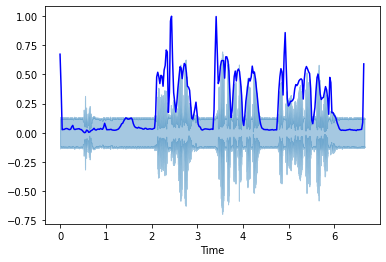

In [79]:
# Normalising the spectral centroid for visualisation


def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)


# Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(librosa_load, sr=librosa_sampling_rate, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')
plt.show()

TypeError: unsupported operand type(s) for +: 'AdaptiveWaveplot' and 'float'

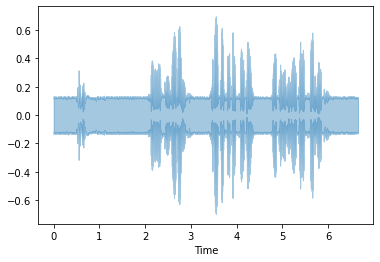

In [70]:
#Enhance transcription data
data["Text_length"] = [len(i) for i in data.text]

In [71]:
data.head()

,key,text,duration,mode,Text_length
0,../data/train/wav/tr_10_tr01010.wav,ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕ...,10.368,mono,77
1,../data/train/wav/tr_100_tr01100.wav,አለቃ የጻፏቸው መጽሀፍት ውድ ና ጣፋጭ ከ መሆናቸው የተነሳ በ ህትመታቸ...,14.592,mono,108
2,../data/train/wav/tr_101_tr02001.wav,በ ኮምፒውተር ሳይንስ ፎን ት ቴክኖሎጂ ለ ዶክትሬት ዲግሪ ጥናት እያደረ...,7.936,mono,90
3,../data/train/wav/tr_102_tr02002.wav,የ ውሀው ዘርፍ ያለበት ን የ ፋይናንስ ችግር ለ መፍታት የ ውሀ ሀብት ...,6.528,mono,67
4,../data/train/wav/tr_103_tr02003.wav,የ መንገደኞች ማስተናገጃ ህንጻው በ ሰአት እስከ ሶስት ሺ ያህል መንገደ...,6.528,mono,63


### Standardize sample rate


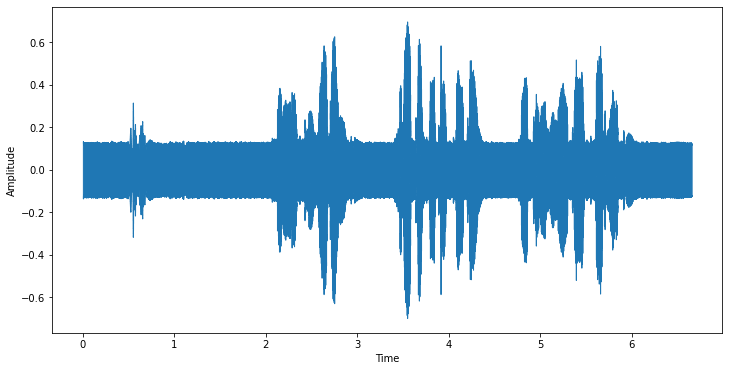

In [72]:
fullpath  =('../data/train/wav/tr_10005_tr097087.wav')
plt.figure(figsize=(12,6))
data,sample_rate=librosa.load(fullpath)
librosa.display.waveshow(data,sr=sample_rate)
plt.xlabel('Time')
plt.ylabel('Amplitude')
ipd.Audio(fullpath)

In [74]:
file  =('../data/train/wav/tr_106_tr02006')
librosa_load, librosa_sampling_rate = librosa.load(fullpath)
scipy_sampling_rate, scipy_load = wav.read(fullpath)
print('original sample rate:',scipy_sampling_rate)
print('converted sample rate:',librosa_sampling_rate)
print('\n')
print('original wav file min~max range:',np.min(scipy_load),'~',np.max(scipy_load))
print('converted wav file min~max range:',np.min(librosa_load),'~',np.max(librosa_load))

original sample rate: 16000
converted sample rate: 22050


original wav file min~max range: -23020 ~ 10380
converted wav file min~max range: -0.6979316 ~ 0.31639597


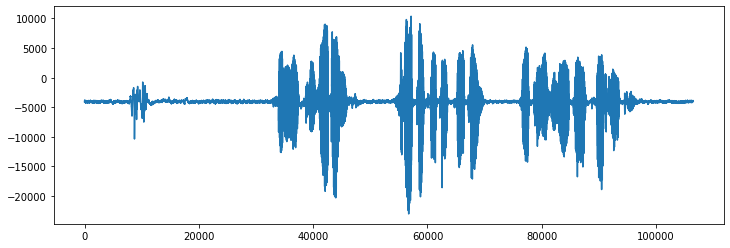

In [75]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_load)

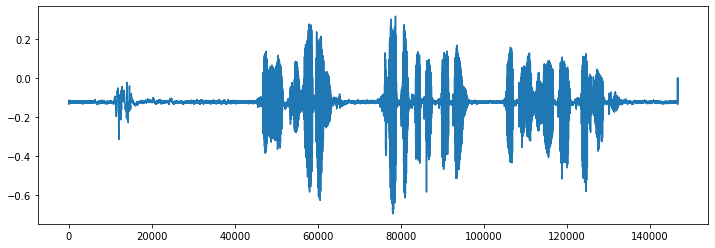

In [76]:
plt.figure(figsize=(12, 4))
plt.plot(librosa_load)